In [1]:
try:
  import qiskit
  import qiskit_aer
  import qiskit_nature
  import qiskit_ibm_runtime
  import pyscf
  import pylatexenc
except:
  !pip install qiskit qiskit-aer qiskit-ibm-runtime qiskit_nature pyscf pylatexenc

# General imports
import numpy as np

# Qiskit Runtime
from qiskit.primitives import Estimator

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper, InterleavedQubitMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms.optimizers import SLSQP, SPSA, COBYLA
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_aer.primitives import Sampler, Estimator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeKolkata



from datetime import datetime


In [3]:
dist = 1.0

In [4]:
# IMPORTANT
def draw_orbitals(problem):
    # Draw orbitals (method provided by Max)
    print(f'Number of particles : {problem.num_particles}')
    print(f'Number of spatial orbitals : {problem.num_spatial_orbitals}')
    print(f'Orbital energies : {problem.orbital_energies}')

    fig, ax = plt.subplots(1, 1, figsize=(16, 10))

    for i in range(problem.num_spatial_orbitals):
        if problem.orbital_occupations[i] == 1:
            co = 'tab:blue'
        else:
            co = 'tab:green'

        ax.scatter(i,np.log10(np.abs(problem.orbital_energies[i])), s=15, c=co, marker='o')

    ax.set_xlabel('Orbital', fontsize=15)
    ax.set_ylabel(r'$\log\left(|E|\right)$', fontsize=15)

    ax.scatter(-2,2,s=15, c='tab:blue', marker='o', label='Occupied orbitals')
    ax.scatter(-2,2,s=15, c='tab:green', marker='o', label='Empty orbitals')
    ax.set_xlim(-0.2,problem.num_spatial_orbitals+0.2)
    ax.set_ylim(np.amin(np.log10(np.abs(problem.orbital_energies)))-0.2,
                np.amax(np.log10(np.abs(problem.orbital_energies)))+0.2)
    ax.legend(loc='best', fontsize=15)

def get_freezed_problem(properties, indexes = None):
    # Shortcut for the problem definition
    return FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=indexes
    ).transform(properties)



## other funcs copied

In [5]:
def exact_solver(qubit_op, problem):
  sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
  result = problem.interpret(sol)
  return result

## func for convenient experimental loop

In [6]:
def Experiment(
  molecule,
  orbitals_to_fix,
  optimizer=COBYLA(maxiter=15, tol=0.0001),
  output_info=True,
  if_draw_orbitals=False,
):
  '''
  returns pair of (exact energy, vqe energy)
  '''
  print(f'= = = = = = = = = = = = = = = = = = = = = = = =\nExperiment started: {(datetime.now().time()).strftime("%H:%M:%S")}')  

  molecule = "".join(molecule)[:-1]
  driver = PySCFDriver(
      atom=molecule,
      unit=DistanceUnit.ANGSTROM,
      basis='sto3g',
      spin=0
  )
  properties_molecule = driver.run()
    
  problem = get_freezed_problem(properties_molecule, orbitals_to_fix)

  if (if_draw_orbitals):
    draw_orbitals(problem)
  if (output_info):
    print('. . . . . . . . . . . . . . . . . . .\n')
  
  # exact solver
  device = FakeKolkata()
  coupling_map = device.configuration().coupling_map
  noise_model = NoiseModel.from_backend(device)
  estimator = Estimator(
        backend_options={"coupling_map": coupling_map, "noise_model": noise_model}
    )
  num_particles = problem.num_particles
  num_spatial_orbitals = problem.num_spatial_orbitals
  mapper = ParityMapper(num_particles=num_particles)
  # mapper = JordanWignerMapper()
  qubit_op = mapper.map(problem.second_q_ops()[0])
  
  exact_result = exact_solver(qubit_op, problem)
  if (output_info):
    print(exact_result)
    print(f'Exact solver done: {(datetime.now().time()).strftime("%H:%M:%S")}')
  
  
  # VQE
  init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
  # TODO: maybe try EfficientSU2 instead of UCCSD
  ansatz = UCCSD(
      num_spatial_orbitals, num_particles, mapper, initial_state=init_state
  )
  if (output_info):
    current_time = datetime.now().time()
    print(f'ansatz initialized, {current_time.strftime("%H:%M:%S")}')
    print(f'ansatz.depth = {ansatz.depth()}')
    print(f'num of qubits = {ansatz.num_qubits}')
  
  vqe = VQE(
        estimator,
        ansatz,
        optimizer,
        initial_point=[0] * ansatz.num_parameters,
    )
  vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
  if (output_info):
    current_time = datetime.now().time()
    print(f'VQE compute_minimum_eigenvalue done, {current_time.strftime("%H:%M:%S")}')

  vqe_result = problem.interpret(vqe_calc)
  if (output_info):
    print(
      f"VQE Result: {vqe_result}\n",
      f"Exact Energy: {exact_result}\n"
    )
  return (exact_result, vqe_result)

In [7]:
lioh_dist_domain = np.linspace(31, 179, 10)

exact_energies = []
vqe_energies = []

# coords=([-dist, 0.0, 0.0], [0.0, 0.0, 0.0], [dist * np.cos(np.deg2rad(180 - hho_deg)), dist * np.sin(np.deg2rad(180 - hho_deg)), 0.0]),
# angle: 104 deg.

dist = 0.9577755948028744
for angle in lioh_dist_domain:
  molecule = [
    'H -'+str(dist)+' .0 .0;',
    'O .0 .0 .0;',
    'H '+str(dist * np.cos(np.deg2rad(180 - angle)))+' '+str(dist * np.sin(np.deg2rad(180 - angle)))+' .0;',
    ]
  print(f"{angle = }")
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)
  exact_energies.append(exact_val)
  vqe_energies.append(vqe_val)


angle = np.float64(31.0)
= = = = = = = = = = = = = = = = = = = = = = = =
Experiment started: 08:51:02
. . . . . . . . . . . . . . . . . . .



/tmp/ipykernel_9210/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_9210/1887286720.py:17: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.468099744442
  - computed part:      -13.109372079476
  - FreezeCoreTransformer extracted energy part: -71.358727664966
~ Nuclear repulsion energy (Hartree): 9.873836881945
> Total ground state energy (Hartree): -74.594262862497
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-3.36134943  0.9321847  0.0]
 
Exact solver done: 08:51:08
ansatz initialized, 08:51:08
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 08:52:31
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -82.597271586499
  - computed part:      -11.238543921533
  - FreezeCoreTransformer extracted energy part: -71.358727664966
~ Nuclear repulsion energy (Hartree): 9.873836881945
> Total ground state energy (Hartree): -72.723434704554
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-3.36134943  0.9321

/tmp/ipykernel_9210/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_9210/1887286720.py:17: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.326987112232
  - computed part:      -12.906882607565
  - FreezeCoreTransformer extracted energy part: -71.420104504667
~ Nuclear repulsion energy (Hartree): 9.526783206647
> Total ground state energy (Hartree): -74.800203905585
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-3.03400027  1.33323674  0.0]
 
Exact solver done: 08:52:34
ansatz initialized, 08:52:34
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 08:53:55
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -82.378878635513
  - computed part:      -10.958774130846
  - FreezeCoreTransformer extracted energy part: -71.420104504667
~ Nuclear repulsion energy (Hartree): 9.526783206647
> Total ground state energy (Hartree): -72.852095428866
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-3.03400027  1.333

/tmp/ipykernel_9210/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_9210/1887286720.py:17: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.259543944416
  - computed part:      -12.822801421553
  - FreezeCoreTransformer extracted energy part: -71.436742522864
~ Nuclear repulsion energy (Hartree): 9.36222585278
> Total ground state energy (Hartree): -74.897318091636
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-2.60650942  1.6252158  0.0]
 
Exact solver done: 08:53:59
ansatz initialized, 08:53:59
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 08:55:20
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -82.241304812042
  - computed part:      -10.804562289178
  - FreezeCoreTransformer extracted energy part: -71.436742522864
~ Nuclear repulsion energy (Hartree): 9.36222585278
> Total ground state energy (Hartree): -72.879078959261
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-2.60650942  1.625215

/tmp/ipykernel_9210/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_9210/1887286720.py:17: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.218307504358
  - computed part:      -12.796645633419
  - FreezeCoreTransformer extracted energy part: -71.421661870939
~ Nuclear repulsion energy (Hartree): 9.268394295524
> Total ground state energy (Hartree): -74.949913208834
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-2.11385017  1.78423491  0.0]
 
Exact solver done: 08:55:24
ansatz initialized, 08:55:24
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 08:56:47
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -82.158449624598
  - computed part:      -10.736787753659
  - FreezeCoreTransformer extracted energy part: -71.421661870939
~ Nuclear repulsion energy (Hartree): 9.268394295524
> Total ground state energy (Hartree): -72.890055329074
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-2.11385017  1.784

/tmp/ipykernel_9210/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_9210/1887286720.py:17: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.179686967782
  - computed part:      -12.789830472325
  - FreezeCoreTransformer extracted energy part: -71.389856495457
~ Nuclear repulsion energy (Hartree): 9.209589333855
> Total ground state energy (Hartree): -74.970097633927
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.59632731  1.79728458  0.0]
 
Exact solver done: 08:56:51
ansatz initialized, 08:56:51
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 08:58:12
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -81.966593015206
  - computed part:      -10.576736519749
  - FreezeCoreTransformer extracted energy part: -71.389856495457
~ Nuclear repulsion energy (Hartree): 9.209589333855
> Total ground state energy (Hartree): -72.757003681351
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.59632731  1.797

/tmp/ipykernel_9210/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_9210/1887286720.py:17: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.135770911254
  - computed part:      -12.784930555618
  - FreezeCoreTransformer extracted energy part: -71.350840355636
~ Nuclear repulsion energy (Hartree): 9.170963672017
> Total ground state energy (Hartree): -74.964807239237
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.09627971  1.66329723  0.0]
 
Exact solver done: 08:58:16
ansatz initialized, 08:58:16
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 08:59:35
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -82.010247785295
  - computed part:      -10.659407429659
  - FreezeCoreTransformer extracted energy part: -71.350840355636
~ Nuclear repulsion energy (Hartree): 9.170963672017
> Total ground state energy (Hartree): -72.839284113278
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-1.09627971  1.663

/tmp/ipykernel_9210/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_9210/1887286720.py:17: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.086335048642
  - computed part:      -12.776645872442
  - FreezeCoreTransformer extracted energy part: -71.3096891762
~ Nuclear repulsion energy (Hartree): 9.145330515777
> Total ground state energy (Hartree): -74.941004532865
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.65461661  1.39323445  0.0]
 
Exact solver done: 08:59:39
ansatz initialized, 08:59:39
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 09:00:57
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -82.047633596888
  - computed part:      -10.737944420688
  - FreezeCoreTransformer extracted energy part: -71.3096891762
~ Nuclear repulsion energy (Hartree): 9.145330515777
> Total ground state energy (Hartree): -72.902303081111
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.65461661  1.3932344

/tmp/ipykernel_9210/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_9210/1887286720.py:17: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.036299666726
  - computed part:      -12.76709079103
  - FreezeCoreTransformer extracted energy part: -71.269208875696
~ Nuclear repulsion energy (Hartree): 9.128893741143
> Total ground state energy (Hartree): -74.907405925583
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.30747073  1.00919025  0.0]
 
Exact solver done: 09:01:01
ansatz initialized, 09:01:01
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 09:02:18
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -82.016224762425
  - computed part:      -10.747015886729
  - FreezeCoreTransformer extracted energy part: -71.269208875696
~ Nuclear repulsion energy (Hartree): 9.128893741143
> Total ground state energy (Hartree): -72.887331021282
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.30747073  1.0091

/tmp/ipykernel_9210/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_9210/1887286720.py:17: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -83.996181583995
  - computed part:      -12.76124130384
  - FreezeCoreTransformer extracted energy part: -71.234940280155
~ Nuclear repulsion energy (Hartree): 9.119588928647
> Total ground state energy (Hartree): -74.876592655348
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.08324233  0.54258353  0.0]
 
Exact solver done: 09:02:22
ansatz initialized, 09:02:22
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 09:03:40
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -82.031650509035
  - computed part:      -10.79671022888
  - FreezeCoreTransformer extracted energy part: -71.234940280155
~ Nuclear repulsion energy (Hartree): 9.119588928647
> Total ground state energy (Hartree): -72.912061580388
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.08324233  0.54258

/tmp/ipykernel_9210/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_9210/1887286720.py:17: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=15, tol=0.0001), orbitals_to_fix=[1, 6], if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -83.979368643477
  - computed part:      -12.759823194169
  - FreezeCoreTransformer extracted energy part: -71.219545449308
~ Nuclear repulsion energy (Hartree): 9.116367239535
> Total ground state energy (Hartree): -74.863001403942
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.00027566  0.0315877  0.0]
 
Exact solver done: 09:03:44
ansatz initialized, 09:03:44
ansatz.depth = 1
num of qubits = 6
VQE compute_minimum_eigenvalue done, 09:05:08
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -82.045240659879
  - computed part:      -10.825695210571
  - FreezeCoreTransformer extracted energy part: -71.219545449308
~ Nuclear repulsion energy (Hartree): 9.116367239535
> Total ground state energy (Hartree): -72.928873420344
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-0.00027566  0.0315

In [8]:
exact_energies_fixed = []
vqe_energies_fixed = []
for el, vl in zip(exact_energies,vqe_energies):
  exact_energies_fixed.append(el.electronic_energies[0] + el.nuclear_repulsion_energy)
  vqe_energies_fixed.append(vl.electronic_energies[0] + vl.nuclear_repulsion_energy)
  

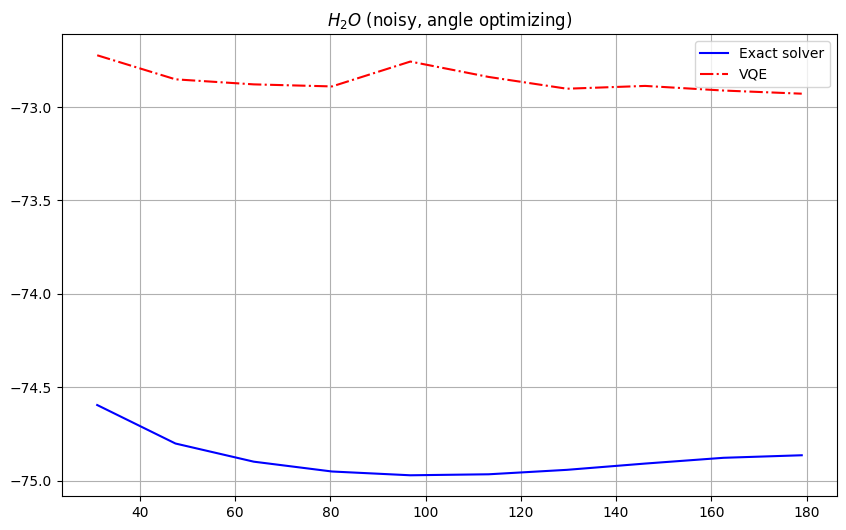

In [9]:
import matplotlib.pyplot as plt

index = 0

plt.figure(figsize=(10, 6))
plt.plot(lioh_dist_domain[index:], exact_energies_fixed[index:], label='Exact solver', linestyle='-', color='b')
plt.plot(lioh_dist_domain[index:], vqe_energies_fixed[index:], label='VQE', linestyle='dashdot', color='r')
plt.title('$H_2O$ (noisy, angle optimizing)')
plt.grid()
plt.legend(loc='best')
plt.show()

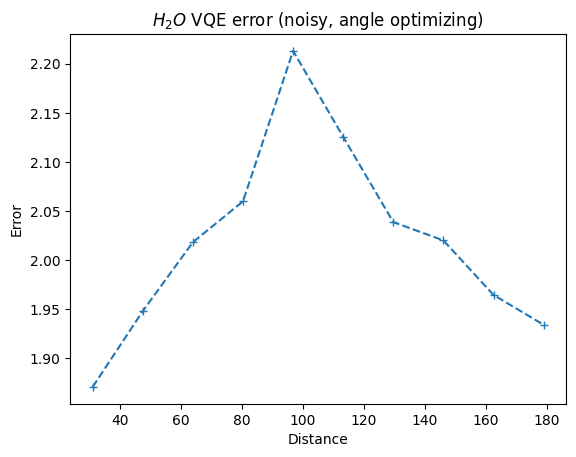

In [10]:
# The error commited at every step remain small

fig, ax = plt.subplots()
# ax.plot(lioh_dist_domain,np.log10(np.abs([vqe_energies[i] - exact_energies_fixed[i] for i in range(len(lioh_dist_domain))])),'+--')
ax.plot(lioh_dist_domain,(np.abs([vqe_energies[i].electronic_energies[0] - exact_energies[i].electronic_energies[0] for i in range(len(lioh_dist_domain))])),'+--')

ax.set_xlabel("Distance")
ax.set_ylabel("Error")
plt.title('$H_2O$ VQE error (noisy, angle optimizing)')

plt.draw()

In [ ]:
np.min(exact_energies_fixed)  # H2

np.float64(-1.1373057587800393)